In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

In [1]:
import transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import gc

In [2]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "lmsys/vicuna-7b-v1.5-16k",
    use_fast=True
)

In [5]:
finetuned_model = transformers.AutoModelForCausalLM.from_pretrained(
    "lmsys/vicuna-7b-v1.5-16k",
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
).to("cuda:0")

base_model = transformers.AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-hf",
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
).to("cuda:0")

finetuned_lora_model = transformers.AutoModelForCausalLM.from_pretrained(
    "lmsys/vicuna-7b-v1.5-16k",
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
).to("cuda:1")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /data/tianle/anaconda3/envs/fastchat/lib/python3.9/site-packages/bitsandbytes-0.39.1-py3.9.egg/bitsandbytes/libbitsandbytes_cuda122.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 122
CUDA SETUP: Loading binary /data/tianle/anaconda3/envs/fastchat/lib/python3.9/site-packages/bitsandbytes-0.39.1-py3.9.egg/bitsandbytes/libbitsandbytes_cuda122.so...


/data/tianle/anaconda3/envs/fastchat/lib/python3.9/site-packages/bitsandbytes-0.39.1-py3.9.egg/bitsandbytes/cuda_setup/main.py:149: UserWarning: /data/tianle/anaconda3/envs/fastchat did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


[2023-10-04 22:27:59,469] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/data/tianle/anaconda3/envs/fastchat/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/data/tianle/anaconda3/envs/fastchat/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
dataset = load_dataset(
    "allenai/c4", 
    data_dir="en",
    split="train",
    data_files=["c4-train.00000-of-01024.json.gz"]
)

Repo card metadata block was not found. Setting CardData to empty.


In [19]:
class LoRADiff(nn.Module):
    def __init__(self, base, finetune, rank=16, niter=20):
        super().__init__()
        diff = finetune - base
        U, S, V = torch.svd_lowrank(diff.T.float(), q=rank, niter=niter)
        self.register_buffer("base", base.T)
        self.register_parameter("A", nn.Parameter((U @ torch.diag_embed(S.sqrt())).to(base.dtype)))
        self.register_parameter("B", nn.Parameter((torch.diag_embed(S.sqrt()) @ V.T).to(base.dtype)))

    def forward(self, x):
        x = x @ self.base + (x @ self.A) @ self.B
        return x

In [36]:
for name, module in finetuned_lora_model.named_modules():
    if "mlp" in name or "self_attn" in name:
        for subname, submodule in module.named_children():
            if "proj" in subname:#isinstance(submodule, nn.Linear) or isinstance(submodule, LoRADiff):
                lora = LoRADiff(
                    base=base_model.get_submodule(name+'.'+subname).weight,
                    finetune=finetuned_model.get_submodule(name+'.'+subname).weight,
                )
                lora.to(finetuned_lora_model.device)
                setattr(module, subname, lora)

In [32]:
input_ids = tokenizer.encode("Hello, my dog is cute", add_special_tokens=True, return_tensors="pt")

In [33]:
with torch.inference_mode():
    finetuned_outputs = finetuned_model(input_ids.to(finetuned_model.device))
    finetuned_lora_outputs = finetuned_lora_model(input_ids.to(finetuned_lora_model.device))

In [34]:
logits_diff = finetuned_outputs.logits.float().cpu() - finetuned_lora_outputs.logits.float().cpu()

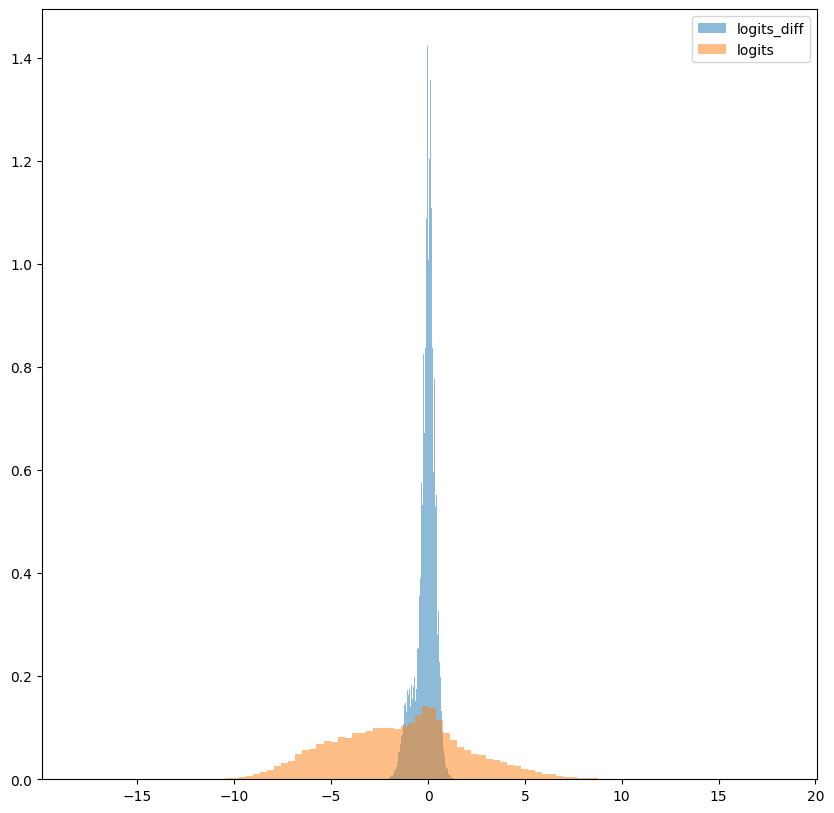

In [35]:
plt.figure(figsize=(10, 10))
_ = plt.hist(logits_diff.numpy().flatten(), bins=100, density=True, alpha=0.5, label="logits_diff")
_ = plt.hist(finetuned_outputs.logits.float().cpu().numpy().flatten(), bins=100, density=True, alpha=0.5, label="logits")

plt.legend()
plt.show()

In [29]:
lora_params = []
for module in finetuned_lora_model.modules():
    if isinstance(module, LoRADiff):
        lora_params.append(module.A)
        lora_params.append(module.B)

In [37]:
loss_list = []
optimizer = torch.optim.AdamW(finetuned_lora_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)
batch_size = 4
for i in range(1000):
    batch = [dataset[i]["text"] for i in range(i*batch_size, (i+1)*batch_size)]
    input_ids = tokenizer(batch, add_special_tokens=True, return_tensors="pt", padding=True, truncation=True, max_length=128)["input_ids"]
    with torch.inference_mode():
        finetuned_outputs = finetuned_model(input_ids.to(finetuned_model.device))
    finetuned_lora_outputs = finetuned_lora_model(input_ids.to(finetuned_lora_model.device))
    logits_diff = finetuned_outputs.logits.to(finetuned_lora_outputs.logits.device) - finetuned_lora_outputs.logits
    loss = torch.mean(logits_diff**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    print(f"Step {i} Loss: {loss.item()}")
    loss_list.append(loss.item())

Step 0 Loss: 1.4344840049743652
Step 1 Loss: 1.6297200918197632
Step 2 Loss: 1.2148760557174683
Step 3 Loss: 1.2612720727920532
Step 4 Loss: 1.2153679132461548
Step 5 Loss: 0.7709403038024902
Step 6 Loss: 1.5735924243927002
Step 7 Loss: 1.348910927772522
Step 8 Loss: 4.887453079223633
Step 9 Loss: 0.9898769855499268
Step 10 Loss: 0.7436172366142273
Step 11 Loss: 1.4289149045944214
Step 12 Loss: 0.7082781195640564
Step 13 Loss: 1.1234809160232544
Step 14 Loss: 0.6222785711288452
Step 15 Loss: 0.5099067687988281
Step 16 Loss: 0.8173118233680725
Step 17 Loss: 1.7781457901000977
Step 18 Loss: 0.7231281995773315
Step 19 Loss: 0.6061674952507019
Step 20 Loss: 1.0211282968521118
Step 21 Loss: 2.187981605529785
Step 22 Loss: 1.59315025806427
Step 23 Loss: 0.8627172112464905
Step 24 Loss: 0.6549533009529114
Step 25 Loss: 0.48943600058555603
Step 26 Loss: 1.1285134553909302
Step 27 Loss: 1.4840129613876343
Step 28 Loss: 0.6545009016990662
Step 29 Loss: 2.4081952571868896
Step 30 Loss: 0.48771029

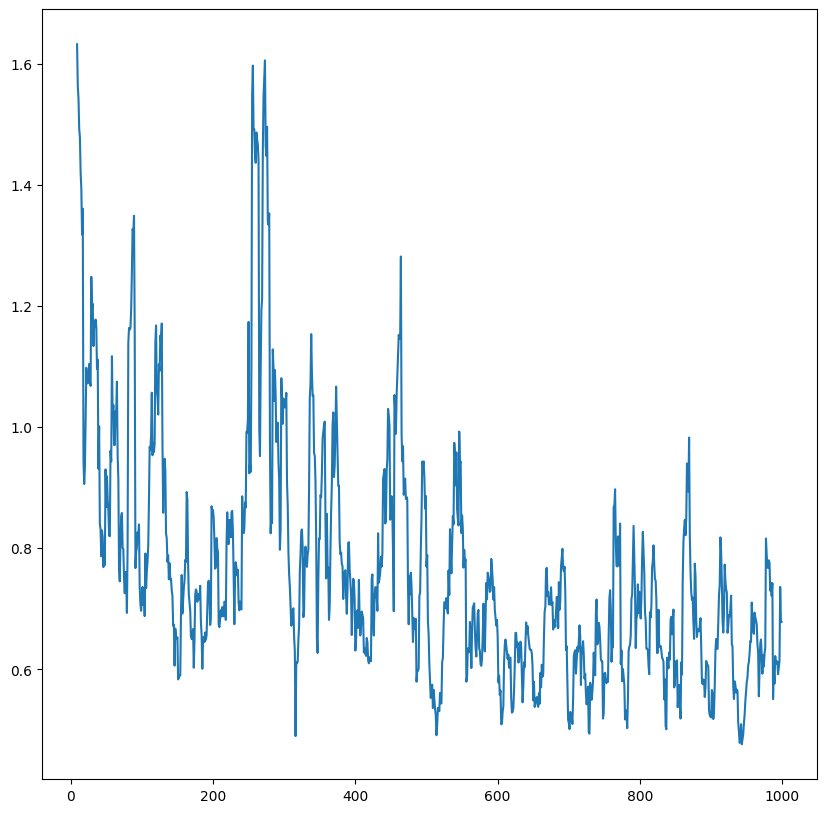

In [38]:
plt.figure(figsize=(10, 10))
# plot smoothed loss
plt.plot(pd.Series(loss_list).rolling(10).mean())

In [17]:
# Update the fine-tuned model with the LoRA parameters
finetuned_model_state_dict = finetuned_model.state_dict()

In [18]:
for name, module in finetuned_lora_model.named_modules():
    if isinstance(module, LoRADiff):
        finetuned_model_state_dict[name+".weight"] = (module.base + (module.A @ module.B)).T

In [19]:
finetuned_model.load_state_dict(finetuned_model_state_dict)

<All keys matched successfully>

In [20]:
finetuned_model.save_pretrained(f"vicuna-7b-v1.5-16k-rank_16_trained")

/data/tianle/anaconda3/envs/fastchat/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:508: UserWarning: The generation config instance is invalid -- `.validate()` throws warnings and/or exceptions. Fix these issues to save the configuration. This warning will be raised to an exception in v4.34.

Thrown during validation:
`do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [36]:
tokenizer.save_pretrained(f"vicuna-7b-v1.5-16k-rank_16_trained")

('vicuna-7b-v1.5-16k-rank_16_trained/tokenizer_config.json',
 'vicuna-7b-v1.5-16k-rank_16_trained/special_tokens_map.json',
 'vicuna-7b-v1.5-16k-rank_16_trained/tokenizer.model',
 'vicuna-7b-v1.5-16k-rank_16_trained/added_tokens.json',
 'vicuna-7b-v1.5-16k-rank_16_trained/tokenizer.json')

In [31]:
finetuned_model_state_dict[name+".weight"].dtype

torch.bfloat16

In [32]:
(module.base + (module.A @ module.B)).T.dtype

torch.bfloat16

In [26]:
finetuned_lora_model_state_dict["model.layers.31.mlp.down_proj.A"].shape

torch.Size([11008, 16])